In [2]:
# Install library
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install h5py
!pip install tslearn
!pip install selenium
!pip install webdriver_manager

In [3]:
# Modules for crawling
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep

In [4]:
# Chrome service
service = ChromeService(executable_path=ChromeDriverManager().install())



====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome
Driver [C:\Users\glenn\.wdm\drivers\chromedriver\win32\101.0.4951.41\chromedriver.exe] found in cache


In [5]:
# Collect symbols
url = 'https://quotes.vcbs.com.vn/a/exchange.html?symbol=HSX'
filename = 'symbols.csv'

driver = webdriver.Chrome(service=service)
driver.get(url)
sleep(3)
body = driver.find_element(By.TAG_NAME, 'body')
div = body.find_elements(By.CLASS_NAME, 'StockSymbolEven')

symbols = []
with open(filename, 'w') as f:
    f.write('Symbols\n')
    for item in div:
        text = item.text
        f.write(text + '\n')
        symbols.append(text)
f.close()
print(len(symbols))

driver.quit()

204


In [8]:
# Collect closing price 2020, 2021, 2022
from IPython.display import clear_output
import random as rd
import os

url = 'https://s.cafef.vn/Lich-su-giao-dich-VNINDEX-1.chn'
driver = webdriver.Chrome(service=service)
driver.get(url)
sleep(1)
used_symbols = []
needed_symbol_quantity = 100
years = [2020, 2021, 2022]
msg = ''
times = 0
os.system('mkdir data')
while len(used_symbols) < needed_symbol_quantity:
    try:
        symbol = symbols[rd.randint(0, len(symbols) - 1)]
        while symbol in used_symbols:
            symbol = symbols[rd.randint(0, len(symbols) - 1)]
        h1 = driver.find_element(By.TAG_NAME, 'h1')
        if len(used_symbols) > 0 and used_symbols[-1] in h1.text and times != 0:
            symbolTxt = driver.find_elements(By.TAG_NAME, 'input')[3]
            driver.execute_script("document.getElementsByTagName('input')[3].value = ''")
            symbolTxt.send_keys(symbol)
            sleep(1)
            label = driver.find_element(By.CLASS_NAME, 'ac_over')
            label.click()
        else:
            try:
                symbolTxt = driver.find_elements(By.TAG_NAME, 'input')[4]
                driver.execute_script("document.getElementsByTagName('input')[4].value = ''")
                symbolTxt.send_keys(symbol)
                sleep(1)
                label = driver.find_element(By.CLASS_NAME, 'ac_over')
                label.click()
            except:
                symbolTxt = driver.find_elements(By.TAG_NAME, 'input')[1]
                driver.execute_script("document.getElementsByTagName('input')[1].value = ''")
                symbolTxt.send_keys(symbol)
                sleep(1)
                label = driver.find_element(By.CLASS_NAME, 'ac_over')
                label.click()
        table = driver.find_elements(By.TAG_NAME, 'table')
        times += 1
        if len(table) > 1:
            sleep(1)
            flag = True
            index = 1
            filename = './data/{}.csv'.format(symbol)
            with open(filename, 'w') as f:
                f.write('Date,Closing Price\n')
                while flag:
                    sleep(1.5)
                    clear_output()
                    print('{}Crawling... {} at page {}'.format(msg, symbol, index))
                    tbody = driver.find_elements(By.TAG_NAME, 'tbody')
                    if len(tbody) < 3:
                        used_symbols = used_symbols[:-1]
                        break
                    trs = tbody[1].find_elements(By.TAG_NAME, 'tr')
                    for tr in trs[2:]:
                        td = tr.find_elements(By.TAG_NAME, 'td')
                        year = int(td[0].text.strip()[-4:])
                        if year in years:
                            try:
                                f.write('{},{}\n'.format(td[0].text.strip(), td[2].text.strip()))
                            except:
                                flag = False
                                break
                        else:
                            flag = False
                            break
                    td = tbody[2].find_elements(By.TAG_NAME, 'td')
                    a = td[len(td) - 1].find_elements(By.TAG_NAME, 'a')
                    try:
                        a[len(a) - 1].click()
                    except:
                        break
                    index += 1
            f.close()
            sleep(0.5)
            if index >= 25:
                used_symbols.append(symbol)
                times = 0
                msg += 'Symbol: {} - Pages: {} - Symbol total: {}\n'.format(symbol, index, len(used_symbols))
            else:
                os.system('rm ./data/{}.csv'.format(used_symbols[-1]))
                used_symbols = used_symbols[:-1]
    except Exception as exception:
        if  exception.__class__.__name__ == 'StaleElementReferenceException':
            os.system('rm ./data/{}.csv'.format(used_symbols[-1]))
            used_symbols = used_symbols[:-1]
        continue
print(len(used_symbols))
driver.quit()

Symbol: PGD - Pages: 31 - Symbol total: 1
Symbol: HAP - Pages: 30 - Symbol total: 2
Symbol: HII - Pages: 31 - Symbol total: 3
Symbol: VCG - Pages: 30 - Symbol total: 4
Symbol: IJC - Pages: 31 - Symbol total: 5
Symbol: HQC - Pages: 32 - Symbol total: 6
Symbol: PPC - Pages: 31 - Symbol total: 7
Symbol: SZC - Pages: 31 - Symbol total: 6
Symbol: HTV - Pages: 31 - Symbol total: 6
Symbol: HVH - Pages: 31 - Symbol total: 7
Symbol: LPB - Pages: 30 - Symbol total: 8
Symbol: HQC - Pages: 31 - Symbol total: 9
Symbol: SKG - Pages: 31 - Symbol total: 10
Symbol: AMD - Pages: 31 - Symbol total: 11
Symbol: ORS - Pages: 30 - Symbol total: 11
Symbol: NTL - Pages: 31 - Symbol total: 12
Symbol: BBC - Pages: 30 - Symbol total: 13
Symbol: ITC - Pages: 31 - Symbol total: 14
Symbol: VPB - Pages: 31 - Symbol total: 15
Symbol: FIT - Pages: 31 - Symbol total: 16
Symbol: PVT - Pages: 31 - Symbol total: 17
Symbol: IMP - Pages: 31 - Symbol total: 18
Symbol: NAF - Pages: 31 - Symbol total: 19
Symbol: VCB - Pages: 31

In [10]:
# Assign data to dictionary (key is date)
from datetime import date

data = {}
for symbol in used_symbols:
    filename = './data/' + symbol + '.csv'
    not_none = []
    
    with open(filename, 'r') as f:
        for line in f.readlines()[1:]:
            values = line.strip().split(',')
            if values[0] not in data.keys():
                data[values[0]] = [float(values[1])]
            else:
                data[values[0]].append(float(values[1]))
            not_none.append(values[0])
    f.close()
    for key in data.keys():
        if key not in not_none:
            data[key].append(0.0)
today = date.today().strftime('%d/%m/%Y')
data.pop(today)  
print(len(data))

585


In [11]:
# Remove unnecessary item
for key in data.keys():
    if len(data[key]) > 100:
        data[key] = data[key][:-(len(data[key]) - 100)]

In [12]:
# Dictionary to dataframe
import pandas as pd

df = pd.DataFrame.from_dict(data, orient='index', columns=used_symbols)
df.head(10)

,PGD,HAP,HII,VCG,IJC,HTV,HVH,LPB,HQC,SKG,...,PGV,TNC,CIG,SAV,CTF,HSG,CTI,GMD,TPB,SCR
10/05/2022,33.0,8.00,10.30,27.45,18.50,13.30,8.02,14.90,5.55,15.90,...,28.90,46.55,10.00,24.60,24.50,24.60,14.80,55.00,33.30,13.70
09/05/2022,32.1,7.76,10.45,27.45,19.10,13.30,7.91,14.65,5.19,15.85,...,29.95,46.55,9.58,24.70,24.70,24.20,15.30,53.50,31.60,14.25
06/05/2022,34.4,8.30,11.20,29.50,20.50,13.85,8.50,15.70,5.57,17.00,...,31.50,48.20,10.30,25.50,25.55,26.00,16.40,56.10,33.60,15.30
05/05/2022,34.8,8.80,11.65,31.50,21.50,14.35,8.70,16.45,5.73,18.20,...,32.10,51.00,11.05,26.00,25.60,24.65,17.40,55.70,34.20,16.10
04/05/2022,34.4,9.06,11.60,31.35,21.60,15.40,8.86,16.80,6.01,18.80,...,32.20,48.00,11.60,27.00,25.50,26.35,17.65,56.50,32.00,16.10
29/04/2022,34.8,9.10,11.75,29.30,21.60,14.50,8.67,16.40,5.88,19.40,...,32.15,48.00,11.00,25.55,25.55,28.30,16.80,54.40,33.60,16.60
28/04/2022,33.6,8.74,11.55,29.00,21.10,13.60,8.69,16.15,5.50,18.50,...,31.90,48.00,10.30,25.50,25.00,28.35,16.40,53.80,33.60,16.30
27/04/2022,33.8,8.50,11.60,29.50,21.05,13.80,8.69,16.25,5.29,18.40,...,31.30,48.15,9.63,25.25,24.20,28.90,16.40,53.30,34.80,17.05
26/04/2022,33.0,8.10,11.20,29.30,20.60,13.90,8.69,16.20,4.95,18.60,...,31.25,48.15,9.00,25.30,24.60,28.40,16.30,51.50,34.95,16.70
25/04/2022,32.1,7.98,11.00,28.80,20.40,13.60,8.64,15.55,4.63,18.15,...,31.50,45.00,8.89,25.50,24.70,28.10,15.60,48.75,34.50,16.45


In [13]:
df[::-1].to_csv('ClosingPrice.csv')

In [1]:
# Read data
import pandas as pd

filename = 'ClosingPrice.csv'
df = pd.read_csv(filename)
df.head(10)

,Unnamed: 0,PGD,HAP,HII,VCG,IJC,HTV,HVH,LPB,HQC,...,PGV,TNC,CIG,SAV,CTF,HSG,CTI,GMD,TPB,SCR
0,02/01/2020,52.00,3.44,9.66,26.5,16.50,13.70,14.25,7.6,1.15,...,9.7,17.80,2.34,9.20,23.50,8.19,23.2,23.20,21.30,5.92
1,03/01/2020,50.80,3.45,9.66,26.1,16.10,14.40,15.20,7.6,1.12,...,9.9,17.80,2.32,9.50,22.25,7.98,22.8,22.75,21.50,5.93
2,06/01/2020,54.00,3.40,9.40,25.9,15.95,13.60,15.85,7.4,1.11,...,10.0,17.80,2.31,9.50,22.25,8.02,22.5,22.25,21.15,5.80
3,07/01/2020,53.90,3.42,9.40,25.8,15.90,13.65,15.55,7.4,1.11,...,10.0,16.60,2.15,9.20,21.70,7.93,21.7,21.75,21.20,5.75
4,08/01/2020,54.50,3.40,9.21,25.4,14.80,13.65,14.80,7.4,1.08,...,10.3,17.70,2.20,9.68,22.50,7.87,21.9,21.00,20.90,5.48
5,09/01/2020,53.90,3.40,9.22,25.4,14.85,13.30,14.60,7.4,1.10,...,10.3,17.90,2.20,9.13,22.60,8.09,21.7,21.70,21.10,5.57
6,10/01/2020,50.20,3.44,9.27,25.6,15.00,13.30,14.45,7.7,1.07,...,10.3,16.65,2.20,9.20,22.90,8.09,21.3,22.00,21.50,5.51
7,13/01/2020,46.70,3.39,9.29,25.6,15.10,13.30,14.55,7.6,1.04,...,10.3,15.50,2.10,9.00,22.95,7.94,21.6,21.50,21.55,5.33
8,14/01/2020,43.45,3.41,9.48,25.6,15.10,13.20,14.60,7.6,1.03,...,9.9,14.45,2.10,9.20,23.15,8.10,21.4,21.50,21.70,5.30
9,15/01/2020,40.55,3.40,9.50,25.6,15.30,12.80,14.40,7.6,1.04,...,10.3,14.45,2.10,9.15,22.80,8.45,21.4,21.35,21.75,5.31


In [2]:
# Normalize data
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

normalizeData = []
for colName in df.columns[1:]:
  tssmv = TimeSeriesScalerMeanVariance()
  normalizeData.append((colName, tssmv.fit_transform([df['DCL']])[0]))

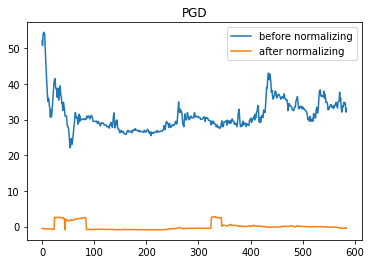

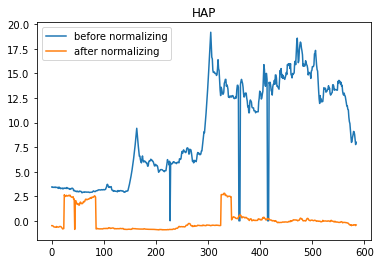

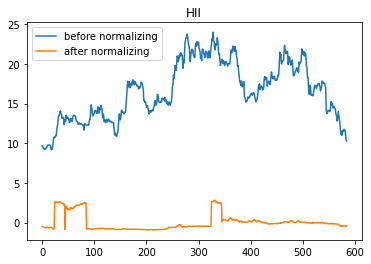

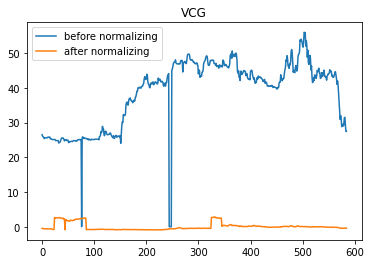

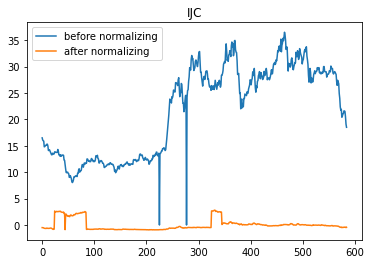

In [3]:
# Show image 5 symbol before normalize and after normalize
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
  x = np.array([i for i in range(len(normalizeData[i][1]))])
  y = np.array(df[normalizeData[i][0]])
  y2 = np.array(normalizeData[i][1])
  fig, ax = plt.subplots()
  ax.plot(x, y, label='before normalizing')
  ax.plot(x, y2, label='after normalizing')
  ax.set_title(normalizeData[i][0])
  ax.legend()

In [17]:
# Train test split
from sklearn.model_selection import train_test_split

X_train
y_train
X_test

NameError: name 'X_train' is not defined

In [ ]:
# Standard Euclidean k-means
from tslearn.clustering import TimeSeriesKMeans

